##  Chargement des données

train_features contient 13 variables explicatives : nombre moyen de pièces par habitation, taux de criminalité,...  
train_medv correspond au prix médian (en k$) des maisons habitées 

In [51]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import boston_housing
from keras import models
from keras import layers
from keras import optimizers

%matplotlib inline

In [52]:
(train_features, train_medv), (test_features, test_medv) = boston_housing.load_data()

In [53]:
train_features[1]

array([2.1770e-02, 8.2500e+01, 2.0300e+00, 0.0000e+00, 4.1500e-01,
       7.6100e+00, 1.5700e+01, 6.2700e+00, 2.0000e+00, 3.4800e+02,
       1.4700e+01, 3.9538e+02, 3.1100e+00])

In [54]:
train_medv[1]

42.3

In [55]:
print("Shape of features " + str(train_features.shape))
print("Shape of medv " + str(train_medv.shape))

Shape of features (404, 13)
Shape of medv (404,)


## Préparation des données
On centre et on réduit les variables explicatives des échantillons d'apprentissage et de test.   
Moyennes et écart-types seront calculés sur l'échantillon d'apprentissage.

In [56]:
mean = train_features.mean(axis=0)
std = train_features.std(axis=0)

train_features = (train_features - mean)/std
test_features = (test_features - mean)/std

#  Définition du modèle

Réseau de neurones avec deux couches cachées de N_1 et N_2 neurones respectivement.
fonctions d'activation ReLU.  


#### La couche de sortie contiendra une seule unité et n'aura pas de fonction d'activation.  


In [57]:
def build_nn(N_1,N_2):
    model = models.Sequential()
    model.add(layers.Dense(N_1, activation = 'relu', input_shape=(train_features.shape[1],)))
    model.add(layers.Dense(N_2, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss='mse', metrics = ['mae'])
    return model

# Validation du modèle 

In [33]:
k = 3
nb_examples = len(train_features) // k
print(nb_examples)

134


In [34]:
nb_epochs = 100
batch_size = 1
N_1 = 32
N_2 = 32
mse_k_cv = []
mae_k_cv = []

for i in range(k):
    print('Echantillon N°'+str(i+1))
    #Validation set
    validation_features = train_features[i*nb_examples:(i+1)*nb_examples]
    validation_medv = train_medv[i*nb_examples:(i+1)*nb_examples]
    
    #training set
    partial_train_features= np.concatenate([train_features[:i*nb_examples],
                                          train_features[(i+1)*nb_examples:]], axis=0)
    
    partial_train_medv= np.concatenate([train_medv[:i*nb_examples],
                                          train_medv[(i+1)*nb_examples:]], axis=0)
    
    model = build_nn(N_1,N_2)
    #verbose = 0 pour ne pas afficher la progression de l'optimisation
    history = model.fit(partial_train_features,partial_train_medv,
             epochs = nb_epochs,batch_size=batch_size, verbose = 0)
    validation_mse, validation_mae = model.evaluate(validation_features,validation_medv)

    
    print("MSE : "+ str(validation_mse))
    mae_k_cv.append(validation_mae)
    mse_k_cv.append(validation_mse)   

Echantillon N°1
134/134 [==============================] - 0s 709us/step
MSE : 12.337526563388199
Echantillon N°2
134/134 [==============================] - 0s 750us/step
MSE : 13.159405807950604
Echantillon N°3
134/134 [==============================] - 0s 777us/step
MSE : 19.861436238929407


In [35]:
print("Mean Absolute Error : " +str(mae_k_cv))

Mean Absolute Error : [2.5468088370650563, 2.6877454643818868, 2.796379847313041]


In [36]:
nb_epochs = 500
batch_size = 1
N_1 = 32
N_2 = 32

mae_history_k_cv = []

for i in range(k):
    print('Echantillon N°'+str(i+1))
    #Validation set
    validation_features = train_features[i*nb_examples:(i+1)*nb_examples]
    validation_medv = train_medv[i*nb_examples:(i+1)*nb_examples]
    
    #training set
    partial_train_features= np.concatenate([train_features[:i*nb_examples],
                                          train_features[(i+1)*nb_examples:]], axis=0)
    
    partial_train_medv= np.concatenate([train_medv[:i*nb_examples],
                                          train_medv[(i+1)*nb_examples:]], axis=0)
    
    model = build_nn(N_1,N_2)
    #verbose = 0 pour ne pas afficher la progression de l'optimisation
    history = model.fit(partial_train_features,partial_train_medv,
             epochs = nb_epochs,batch_size=batch_size, verbose = 0,
                       validation_data = (validation_features,validation_medv))
    
    mae_history = history.history['val_mean_absolute_error']
    
    mae_history_k_cv.append(mae_history)
    

Echantillon N°1
Echantillon N°2
Echantillon N°3


In [37]:
#On moyenne pour chaque epoch la MAE sur les k champs de validation
avg_mae_history = [np.mean([x[i] for x in mae_history_k_cv]) for i in range(nb_epochs)]

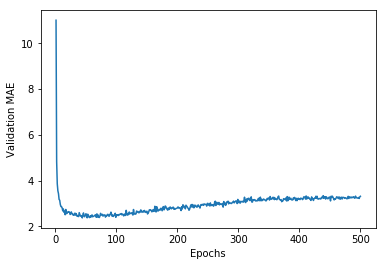

In [38]:
plt.plot(range(1,nb_epochs+1),avg_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

On lisse la courbe en utilisant une moyenne exponentielle mobile sur 10 points

In [40]:
def ewma(points, factor=0.9):
    ewma_points = []
    
    for point in points:
        if ewma_points:
            previous = ewma_points[-1]
            ewma_points.append(previous*factor+point*(1-factor))
        else:
            ewma_points.append(point)
            
    return ewma_points      
        
    

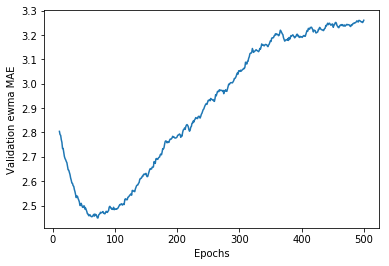

In [42]:
ewma_mae = ewma(avg_mae_history[10:])

plt.plot(range(11,nb_epochs+1),ewma_mae)
plt.xlabel("Epochs")
plt.ylabel("Validation ewma MAE")
plt.show()

In [48]:
np.argsort(ewma_mae)

array([ 61,  62,  52,  51,  53,  60,  56,  50,  47,  48,  54,  58,  63,
        49,  59,  55,  64,  57,  46,  73,  45,  65,  72,  71,  67,  74,
        68,  77,  69,  66,  70,  76,  44,  75,  78,  79,  43,  88,  86,
        90,  92,  84,  85,  41,  89,  91,  93,  94,  42,  83,  82,  38,
        87,  37,  80,  95,  81,  96,  40,  39,  33,  34,  36, 101,  98,
       102,  97, 104,  99, 100, 103,  35,  32,  31, 105, 109, 107, 108,
       106,  30,  27, 110, 111,  29, 112,  28, 116, 113, 114,  26, 115,
        25, 121, 120, 119, 117, 118,  24, 122, 123,  23,  22, 124, 125,
       126,  21, 127,  20, 128,  19, 129, 131, 130,  18, 132, 141, 134,
       133, 142, 140, 135,  17, 137, 138, 136, 143, 139,  16, 144,  15,
        14, 145, 147, 148, 146, 150, 149, 151,  13, 154,  12, 153, 152,
        11,  10, 158, 157, 155, 156,   9, 159, 160, 161,   8, 164, 162,
       163,   7, 165, 167, 166,   5,   6, 168, 169, 173, 175, 176,   4,
       174, 172, 170, 171, 177,   3, 179, 178, 180, 186, 187, 18

# Modèle final
Apprentissage sur toutes les données du train set, model performance

In [58]:
nb_epochs = 61
model = build_nn(32,32)
model.fit(train_features,train_medv, epochs =nb_epochs, batch_size=16, verbose =0)

test_mse, test_mae = model.evaluate(test_features, test_medv)
print("Test MSE : "+ str(test_mse))
print("Test MAE : "+ str(test_mae))


102/102 [==============================] - 0s 1ms/step
Test MSE : 19.891983331418505
Test MAE : 2.896337911194446
